###### The code below is for the SubSampler Class, which we will use to train the model using only a fraction of the data.


In [1]:
import torch.utils.data.sampler as samplers

class SubsetSampler(samplers.Sampler):

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

# Models

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet34


class FaceNetModel(nn.Module):
    def __init__(self, embedding_size, num_classes, pretrained=False):
        super (FaceNetModel, self).__init__()
        
        self.model = resnet34(pretrained)
        self.embedding_size = embedding_size
        self.model.fc = nn.Linear(8192, self.embedding_size)
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)
    
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer = torch.pow(input, 2)
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        _output = torch.div(input, norm.view(-1, 1).expand_as(input))
        output = _output.view(input_size)
    
        return output
    
    
    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha         = 10
        self.features = self.features*alpha
        
        return self.features
    
    
    def forward_classifier(self, x):
        features = self.forward(x)
        res      = self.model.classifier(features)
        
        return res

# Training function

In [3]:
def train_valid(model, optimizer, scheduler, epoch, dataloaders, data_size, margin):
    
    for phase in ['train', 'valid']:

        labels, distances = [], []
        triplet_loss_sum  = 0.0

        if phase == 'train':
            optimizer.zero_grad()
            optimizer.step()
            scheduler.step()
            model.train()
        else:
            model.eval()
        
        for batch_idx, batch_sample in enumerate(dataloaders[phase]):
            
            anc_img = batch_sample['anc_img'].to(device)
            pos_img = batch_sample['pos_img'].to(device)
            neg_img = batch_sample['neg_img'].to(device)
        
            pos_cls = batch_sample['pos_class'].to(device)
            neg_cls = batch_sample['neg_class'].to(device)
                            
            with torch.set_grad_enabled(phase == 'train'):
            
                # anc_embed, pos_embed and neg_embed are encoding(embedding) of image
                anc_embed, pos_embed, neg_embed = model(anc_img), model(pos_img), model(neg_img)
            
                # choose the hard negatives only for "training"
                pos_dist = l2_dist.forward(anc_embed, pos_embed)
                neg_dist = l2_dist.forward(anc_embed, neg_embed)
            
                all = (neg_dist - pos_dist < margin).cpu().numpy().flatten()
                if phase == 'train':
                    hard_triplets = np.where(all == 1)
                    if len(hard_triplets[0]) == 0:
                        continue
                else:
                    hard_triplets = np.where(all >= 0)
                
                anc_hard_embed = anc_embed[hard_triplets].to(device)
                pos_hard_embed = pos_embed[hard_triplets].to(device)
                neg_hard_embed = neg_embed[hard_triplets].to(device)
            
                anc_hard_img  = anc_img[hard_triplets].to(device)
                pos_hard_img  = pos_img[hard_triplets].to(device)
                neg_hard_img  = neg_img[hard_triplets].to(device)
            
                pos_hard_cls  = pos_cls[hard_triplets].to(device)
                neg_hard_cls  = neg_cls[hard_triplets].to(device)
            
                anc_img_pred  = model.forward_classifier(anc_hard_img).to(device)
                pos_img_pred  = model.forward_classifier(pos_hard_img).to(device)
                neg_img_pred  = model.forward_classifier(neg_hard_img).to(device)
            
                triplet_loss  = TripletLoss(margin).forward(anc_hard_embed, pos_hard_embed, neg_hard_embed).to(device)
        
                if phase == 'train':
                    optimizer.zero_grad()
                    triplet_loss.backward()
                    optimizer.step()
            
                dists = l2_dist.forward(anc_embed, pos_embed)
                distances.append(dists.data.cpu().numpy())
                labels.append(np.ones(dists.size(0))) 

                dists = l2_dist.forward(anc_embed, neg_embed)
                distances.append(dists.data.cpu().numpy())
                labels.append(np.zeros(dists.size(0)))
                
                loss_sum_batch = triplet_loss.item()
                triplet_loss_sum += triplet_loss.item()
                          
        avg_triplet_loss = triplet_loss_sum / data_size[phase]
        labels = np.array([sublabel for label in labels for sublabel in label])
        distances = np.array([subdist for dist in distances for subdist in dist])
            
        if phase == 'valid':
            return distances, labels, avg_triplet_loss

# Data loader

In [4]:
import os
import numpy as np
import pandas as pd
from skimage import io
import torch
from torchvision import transforms
from torch.utils.data import Dataset


class TripletFaceDataset(Dataset):

    def __init__(self, root_dir, csv_name, num_triplets, transform = None):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(csv_name)
        self.num_triplets = num_triplets
        self.transform = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_triplets)
    
    
    @staticmethod
    def generate_triplets(df, num_triplets):
        
        def make_dictionary_for_face_class(df):

            '''
              - face_classes = {'class0': [class0_id0, ...], 'class1': [class1_id0, ...], ...}
            '''
            face_classes = dict()
            for idx, label in enumerate(df['class']):
                if label not in face_classes:
                    face_classes[label] = []
                face_classes[label].append(df.iloc[idx, 0])
            return face_classes
        
        triplets = []
        classes = df['class'].unique()
        face_classes = make_dictionary_for_face_class(df)
         
        for _ in range(num_triplets):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''
        
            pos_class = np.random.choice(classes)
            neg_class = np.random.choice(classes)
            while len(face_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)
            while pos_class == neg_class:
                neg_class = np.random.choice(classes)
            
            pos_name = df.loc[df['class'] == pos_class, 'name'].values[0]
            neg_name = df.loc[df['class'] == neg_class, 'name'].values[0]

            if len(face_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size = 2, replace = False)
            else:
                ianc = np.random.randint(0, len(face_classes[pos_class]))
                ipos = np.random.randint(0, len(face_classes[pos_class]))
                while ianc == ipos:
                    ipos = np.random.randint(0, len(face_classes[pos_class]))
            ineg = np.random.randint(0, len(face_classes[neg_class]))
            
            triplets.append([face_classes[pos_class][ianc], face_classes[pos_class][ipos], face_classes[neg_class][ineg], 
                             pos_class, neg_class, pos_name, neg_name])
        
        return triplets
    
    
    def __getitem__(self, idx):
        
        anc_id, pos_id, neg_id, pos_class, neg_class, pos_name, neg_name = self.training_triplets[idx]
        
        anc_img   = os.path.join(self.root_dir, str(pos_name), str(anc_id) + '.jpg')
        pos_img   = os.path.join(self.root_dir, str(pos_name), str(pos_id) + '.jpg')
        neg_img   = os.path.join(self.root_dir, str(neg_name), str(neg_id) + '.jpg')
        
        anc_img   = io.imread(anc_img)
        pos_img   = io.imread(pos_img)
        neg_img   = io.imread(neg_img)

        pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))
        neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))
        
        sample = {'anc_img': anc_img, 'pos_img': pos_img, 'neg_img': neg_img, 'pos_class': pos_class, 'neg_class': neg_class}

        if self.transform:
            sample['anc_img'] = self.transform(sample['anc_img'])
            sample['pos_img'] = self.transform(sample['pos_img'])
            sample['neg_img'] = self.transform(sample['neg_img'])
            
        return sample
    
    
    def __len__(self):
        
        return len(self.training_triplets)
    

def get_dataloader(train_root_dir,     valid_root_dir, 
          train_csv_name,     valid_csv_name, 
          num_train_triplets, num_valid_triplets):
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])]),
        'valid': transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])}

    face_dataset = {
        'train' : TripletFaceDataset(root_dir     = train_root_dir,
                                  csv_name = train_csv_name,
                                  num_triplets = num_train_triplets,
                                  transform = data_transforms['train']),
        'valid' : TripletFaceDataset(root_dir     = valid_root_dir,
                                  csv_name = valid_csv_name,
                                  num_triplets = num_valid_triplets,
                                  transform = data_transforms['valid'])}

    return face_dataset

# Utils

In [5]:
import torch
from torch.autograd import Function
from torch.nn.modules.distance import PairwiseDistance


class TripletLoss(Function):
    
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist  = PairwiseDistance(2)
        
    def forward(self, anchor, positive, negative):
        pos_dist = self.pdist.forward(anchor, positive)
        neg_dist = self.pdist.forward(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss = torch.mean(hinge_dist)
        return loss

# Evaluation metrics

In [6]:
import operator
import numpy as np
from sklearn.model_selection import KFold
from scipy import interpolate


def evaluate(distances, labels, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 30, 0.01)
    tpr, fpr, accuracy = calculate_roc(thresholds, distances,
        labels, nrof_folds=nrof_folds)
    thresholds = np.arange(0, 30, 0.001)
    val, val_std, far = calculate_val(thresholds, distances,
        labels, 1e-3, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far


def calculate_roc(thresholds, distances, labels, nrof_folds=10):

    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, distances[train_set], labels[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, distances[test_set], labels[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], distances[test_set], labels[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc


def calculate_val(thresholds, distances, labels, far_target=1e-3, nrof_folds=10):
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, distances[train_set], labels[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, distances[test_set], labels[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    if n_diff == 0:
        n_diff = 1
    if n_same == 0:
        return 0,0
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far


def plot_roc(fpr,tpr,figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import roc_curve, auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    fig.savefig(figure_name, dpi=fig.dpi)

# AL

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn.modules.distance import PairwiseDistance
import torchvision
from torchvision import transforms
import random
% matplotlib inline

In [8]:
num_epochs = 5
num_classes = 5760
num_train_triplets = 5760 #1280  
num_valid_triplets = 2000 #640
embedding_size = 128
batch_size = 64 
num_workers = 4
learning_rate = 0.001
margin = 0.5
train_root_dir = './train/'
valid_root_dir = './val/'
train_csv_name = './train/lfw_train.csv'
valid_csv_name = './val/lfw_valid.csv'
num_steps = 9 #5        
nps = int(num_train_triplets / num_steps)

device  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
l2_dist = PairwiseDistance(2)

- Let us show some of the training images.

In [9]:
# face_dataset = get_dataloader(train_root_dir,     valid_root_dir, 
#                               train_csv_name,     valid_csv_name, 
#                               num_train_triplets, num_valid_triplets)
# dataloaders = {
#         x: torch.utils.data.DataLoader(face_dataset[x], batch_size = batch_size, shuffle = False, num_workers = num_workers)
#         for x in ['train', 'valid']}
    
# size = {x: len(face_dataset[x]) for x in ['train', 'valid']}

# df = pd.read_csv(valid_csv_name) 
# classes = tuple(sorted(set(df['name']),key=list(df['name']).index))

# # functions to show an image
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images
# mydataiter = iter(dataloaders['valid'])
# mydata = mydataiter.next()
# myimages, mylabels = mydata['anc_img'], mydata['pos_class']
# myimage, mylabel = myimages[0:4], mylabels[0:4]
# # show images
# imshow(torchvision.utils.make_grid(myimage))
# # print labels
# print(' '.join('%5s' % classes[mylabel[j]] for j in range(4)))

## AL Class

In [10]:
class ActiveStrategy(object):

    def __init__(self, model, nsteps, margin, num_epochs, batch_size, num_workers):
        self.model = model
        self.nsteps = nsteps
        self.margin = margin
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.face_dataset = get_dataloader(train_root_dir,     valid_root_dir,
                                           train_csv_name,     valid_csv_name,
                                           num_train_triplets, num_valid_triplets)
        self.statsloader = torch.utils.data.DataLoader(self.face_dataset['train'], 
                                                       batch_size = self.batch_size, 
                                                       shuffle = False,
                                                       num_workers = self.num_workers)
        self.trainloader = torch.utils.data.DataLoader(self.face_dataset['train'], 
                                                       batch_size = self.batch_size, 
                                                       shuffle = False,
                                                       num_workers = self.num_workers)
        self.validloader = torch.utils.data.DataLoader(self.face_dataset['valid'], 
                                                       batch_size = self.batch_size, 
                                                       shuffle = False,
                                                       num_workers = self.num_workers)
        self.data_loader = {'train': self.trainloader, 'valid': self.validloader}
        self.train_length = len(self.face_dataset['train'])
        self.valid_length = len(self.face_dataset['valid'])
        self.train_filter = [ i for i in range(self.train_length)]
        self.valid_filter = [ i for i in range(self.valid_length)]
        self.train_sampler = SubsetSampler(self.train_filter)
        self.valid_sampler = SubsetSampler(self.valid_filter)
        self.experiments = []

    def incremental_supervised(self):
        np.random.shuffle(self.train_filter)
        
    def train_test(self,data_size):
        optimizer = optim.Adam(model.parameters(), lr = learning_rate)
        scheduler = lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.1)

        for epoch in range(num_epochs):

            distances, labels, avg_triplet_loss = train_valid(self.model, optimizer, scheduler, epoch, self.data_loader, data_size, self.margin)
            
        print('Finished Training')
        return distances, labels, avg_triplet_loss
        
        ##### Stats below ######  

    def infer(self, sample):
        sampler = SubsetSampler(sample)
        dataloader = torch.utils.data.DataLoader(self.face_dataset['train'],
                                                  shuffle=False,
                                                  batch_size=1,
                                                  num_workers=self.num_workers,
                                                  sampler=sampler)
        results = []
        labels, distances = [], []
        model.eval()
        for r, rec in enumerate(dataloader):
            anc_img = rec['anc_img'].to(device)
            pos_img = rec['pos_img'].to(device)
            neg_img = rec['neg_img'].to(device)
        
            pos_cls = rec['pos_class'].to(device)
            neg_cls = rec['neg_class'].to(device)
                
            with torch.no_grad():
                anc_embed, pos_embed, neg_embed = model(anc_img), model(pos_img), model(neg_img)
                
                pos_dist = l2_dist.forward(anc_embed, pos_embed)
                neg_dist = l2_dist.forward(anc_embed, neg_embed)
                
                all = (neg_dist - pos_dist < margin).cpu().numpy().flatten()
                
                hard_triplets = np.where(all >= 0)

                anc_hard_embed = anc_embed[hard_triplets].to(device)
                pos_hard_embed = pos_embed[hard_triplets].to(device)
                neg_hard_embed = neg_embed[hard_triplets].to(device)
            
                anc_hard_img  = anc_img[hard_triplets].to(device)
                pos_hard_img  = pos_img[hard_triplets].to(device)
                neg_hard_img  = neg_img[hard_triplets].to(device)
            
                pos_hard_cls  = pos_cls[hard_triplets].to(device)
                neg_hard_cls  = neg_cls[hard_triplets].to(device)
            
                anc_img_pred  = model.forward_classifier(anc_hard_img).to(device)
                pos_img_pred  = model.forward_classifier(pos_hard_img).to(device)
                neg_img_pred  = model.forward_classifier(neg_hard_img).to(device)
            
                triplet_loss  = TripletLoss(margin).forward(anc_hard_embed, pos_hard_embed, neg_hard_embed).to(device)
                
                dists1 = l2_dist.forward(anc_embed, pos_embed)
                distances.append(dists1.data.cpu().numpy())
                labels.append(np.ones(dists1.size(0))) 

                dists0 = l2_dist.forward(anc_embed, neg_embed)
                distances.append(dists0.data.cpu().numpy())
                labels.append(np.zeros(dists0.size(0)))
                
            results.append([r,triplet_loss.item(),dists1.data.cpu().numpy(),dists0.data.cpu().numpy()])
        return results                
    
    def run_one(self, selected):
        self.train_filter = selected
        print("Training for {0} records:".format(len(selected)))
        self.train_sampler = SubsetSampler(self.train_filter)
        self.trainloader = torch.utils.data.DataLoader(self.face_dataset['train'],
                                                       shuffle=False,
                                                       batch_size=self.batch_size,
                                                       num_workers=self.num_workers,
                                                       sampler=self.train_sampler)
        self.data_loader = {'train': self.trainloader, 'valid': self.validloader}
        data_size = {'train':len(selected),'valid':self.valid_length}
        distances, labels, avg_triplet_loss = self.train_test(data_size)
        tpr, fpr, accuracy, val, val_std, far = evaluate(distances, labels)
        print('Triplet Loss = {:.8f}'.format(avg_triplet_loss))
        print('Accuracy of the network on the {0} test images: {1}%'.format(self.valid_length,100 * np.mean(accuracy)))
        res = np.mean(accuracy)
        return res
    
    def run_experiment(self, nsteps):
        results = []
        for n in range(1, nsteps+1):
            nsamples = int(1.0 / nsteps * n * self.train_length)
            print("Training for {0} samples:".format(nsamples))
            self.train_sampler = SubsetSampler(self.train_filter[:nsamples])
            self.trainloader = torch.utils.data.DataLoader(self.face_dataset['train'],
                                                           shuffle=False,
                                                           batch_size=self.batch_size,
                                                           num_workers=self.num_workers,
                                                           sampler=self.train_sampler)
            self.data_loader = {'train': self.trainloader, 'valid': self.validloader}
            data_size = {x: nsamples for x in ['train', 'valid']}
            distances, labels, avg_triplet_loss = self.train_test(data_size)
            tpr, fpr, accuracy, val, val_std, far = evaluate(distances, labels)
            print('Triplet Loss = {:.8f}'.format(avg_triplet_loss))
            print('Accuracy of the network on the {0} test images: {1}%'.format(self.valid_length,100 * np.mean(accuracy)))
            results.append(np.mean(accuracy))
        return results
    
    def run_ConfidenceAL(self, qStrategy, nsteps, maximum):
    
        results = []
    
        unlabeled = [i for i in range(self.train_length)]
        labeled   = []
        l = []

        to_be_labeled = random.sample(unlabeled, int(nps))
        l.append(len(to_be_labeled))
        
        unlabeled = list(set(unlabeled)-set(to_be_labeled))
        myres = self.run_one(to_be_labeled)
        results.append(myres)
    
        for n in range(1, nsteps):
            myResults = self.infer(unlabeled)
            to_be_labeled.extend(qStrategy(myResults, int(maximum/nsteps))) # updating function
            unlabeled = list(set(unlabeled)-set(to_be_labeled))
            myres = self.run_one(to_be_labeled)
            results.append(myres)
            l.append(len(to_be_labeled))
        
        return results,l
    
    def run_StreamingAL(self, qStrategy, nsteps, maximum):
    
        results = []
        stepSizes = []
    
        unlabeled = [i for i in range(self.train_length)]
        labeled   = []

        to_be_labeled = random.sample(unlabeled, int(nps))
        unlabeled = list(set(unlabeled)-set(to_be_labeled))
        myres = self.run_one(to_be_labeled)
        results.append(myres)
        stepSizes.append(len(to_be_labeled))
    
        for n in range(1, nsteps):
            myResults = self.infer(unlabeled)
            to_be_labeled.extend( qStrategy(myResults) ) # updating function
            if (len(to_be_labeled) > maximum):
                break
            unlabeled = list(set(unlabeled)-set(to_be_labeled))
            myres = self.run_one(to_be_labeled)
            results.append(myres)
            stepSizes.append(len(to_be_labeled))
        
        return results, stepSizes

## Active learning Process

### Baseline model

In [11]:
%%time

model = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy = ActiveStrategy(model, num_steps, margin, num_epochs, batch_size, num_workers)

myActiveStrategy.incremental_supervised()
mySupervised = myActiveStrategy.run_experiment(num_steps)
    
# plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised, '--b', marker="o")

Training for 640 samples:
Finished Training
Triplet Loss = 0.01897776
Accuracy of the network on the 2000 test images: 61.925%
Training for 1280 samples:
Finished Training
Triplet Loss = 0.00911205
Accuracy of the network on the 2000 test images: 64.7%
Training for 1920 samples:
Finished Training
Triplet Loss = 0.00442665
Accuracy of the network on the 2000 test images: 71.10000000000001%
Training for 2560 samples:
Finished Training
Triplet Loss = 0.00328737
Accuracy of the network on the 2000 test images: 72.6%
Training for 3200 samples:
Finished Training
Triplet Loss = 0.00241750
Accuracy of the network on the 2000 test images: 74.0%
Training for 3840 samples:
Finished Training
Triplet Loss = 0.00157815
Accuracy of the network on the 2000 test images: 77.67500000000001%
Training for 4479 samples:
Finished Training
Triplet Loss = 0.00132213
Accuracy of the network on the 2000 test images: 78.975%
Training for 5120 samples:
Finished Training
Triplet Loss = 0.00105452
Accuracy of the ne

In [12]:
# # save results
# df = pd.DataFrame(mySupervised)
# df.to_csv('data.csv',index=False)
# plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised, '--b', marker="o")
# plt.savefig("mySupervised.png")

### Uncertainty-Based Strategies

In [13]:
%%time

unlabeled = [i for i in range(num_train_triplets)]
labeled   = []

to_be_labeled = random.sample(unlabeled, nps) # generate a random sample of the data, size nps (defined previously)
to_be_labeled_set = set(to_be_labeled)

unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update the unlabeled array once you defined to_be_labeled

model1 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy1 = ActiveStrategy(model1, num_steps, margin, num_epochs, batch_size, num_workers)
myActiveStrategy1.run_one(to_be_labeled)

Training for 640 records:
Finished Training
Triplet Loss = 0.00983943
Accuracy of the network on the 2000 test images: 50.675000000000004%
CPU times: user 1min 30s, sys: 23.7 s, total: 1min 53s
Wall time: 2min 34s


In [14]:
%%time

myResults = myActiveStrategy1.infer(unlabeled)
# myResults[:10]

# Below, we update the to_be_labeled and unlabeled arrays, in preparation for the next loop...
# the strategy is to select the records that were inferred with the lowest confidence in the previous loop...
sorted_by_conf = sorted(myResults, key=lambda x: abs(float(x[2]-x[3])))[:nps] # fill here; remember that the size of the array will be 'nps'


# update to_be_labeled:
to_be_labeled.extend([row[0] for row in sorted_by_conf])
to_be_labeled_set = set(to_be_labeled)

unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

# And run one more loop...
accuracy = myActiveStrategy1.run_one(to_be_labeled)

Training for 1280 records:
Finished Training
Triplet Loss = 0.00990282
Accuracy of the network on the 2000 test images: 51.275000000000006%
CPU times: user 5min 32s, sys: 40.4 s, total: 6min 12s
Wall time: 6min 54s


### Drawing the distribution of the confidence level

[0.6367144584655762, 3.6567206382751465, 0.46340084075927734, 3.904067039489746, 2.0712876319885254, 3.6652796268463135, 3.0595905780792236, 2.1878249645233154, 2.460099220275879, 2.0024731159210205]
5120
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 45.7 ms


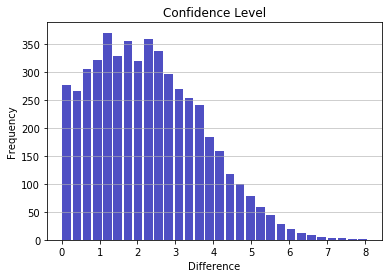

In [15]:
%%time
# confidence level on triplet loss: d(a,p)-d(a,n)
inferred_CL = [abs(float(c[2] - c[3])) for c in myResults]
print(inferred_CL[:10])
print(len(inferred_CL))

n, bins, patches = plt.hist(x=inferred_CL, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Confidence Level')
maxfreq = n.max()

plt.ylim(top=(np.ceil(maxfreq / 10) * 10 * 1.05) if maxfreq % 10 else (maxfreq + 10) * 1.05)

[0.0, 0.0, 0.036599159240722656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5120
CPU times: user 60 ms, sys: 56 ms, total: 116 ms
Wall time: 37.5 ms


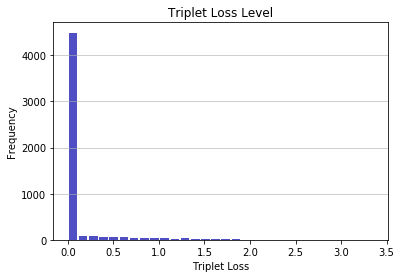

In [16]:
%%time
# confidence level on triplet loss: max(d(a,p)-d(a,n)+margin,0)
inferred_CL = [float(c[1]) for c in myResults]
print(inferred_CL[:10])
print(len(inferred_CL))

n1, bins, patches = plt.hist(x=inferred_CL, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Triplet Loss')
plt.ylabel('Frequency')
plt.title('Triplet Loss Level')
maxfreq1 = n1.max()

plt.ylim(top=(np.ceil(maxfreq1 / 10) * 10 * 1.05) if maxfreq1 % 10 else (maxfreq1 + 10) * 1.05)

In [17]:
# df = pd.DataFrame(myResults)
# df.to_csv('results.csv',index=False)

In [18]:
# mySupervised = pd.read_csv(filepath_or_buffer='data.csv')
# mySupervised = np.array(mySupervised).tolist()

In [19]:
%%time

model2 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy2 = ActiveStrategy(model2, num_steps, margin, num_epochs, batch_size, num_workers)

def confidenceAL(nsteps, stepSize):
    
    results = []
    
    unlabeled = [i for i in range(num_train_triplets)]
    labeled   = []
    
    to_be_labeled = random.sample(unlabeled, stepSize)
    to_be_labeled_set = set(to_be_labeled)
    unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled))
    
    myres = myActiveStrategy2.run_one(to_be_labeled)
    results.append(myres)
    
    for n in range(1, nsteps):
        myResults = myActiveStrategy2.infer(unlabeled)
        sorted_by_conf = sorted(myResults, key=lambda x: abs(float(x[2]-x[3])))[:stepSize] 

        # update to_be_labeled:
        to_be_labeled.extend([row[0] for row in sorted_by_conf])
        to_be_labeled_set = set(to_be_labeled)
        unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

        myres = myActiveStrategy2.run_one(to_be_labeled)
        results.append(myres)
        
    return results
 
myConfidenceAL = confidenceAL(num_steps, nps)
# plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
#          [nps*i for i in range(1, num_steps + 1)], myConfidenceAL,  '--g',
#          marker = "o")

Training for 640 records:
Finished Training
Triplet Loss = 0.00921507
Accuracy of the network on the 2000 test images: 50.29999999999999%
Training for 1280 records:
Finished Training
Triplet Loss = 0.00925913
Accuracy of the network on the 2000 test images: 53.37499999999999%
Training for 1920 records:
Finished Training
Triplet Loss = 0.00933981
Accuracy of the network on the 2000 test images: 50.525%
Training for 2560 records:
Finished Training
Triplet Loss = 0.00935604
Accuracy of the network on the 2000 test images: 51.17499999999999%
Training for 3200 records:
Finished Training
Triplet Loss = 0.00923418
Accuracy of the network on the 2000 test images: 52.175%
Training for 3840 records:
Finished Training
Triplet Loss = 0.00935651
Accuracy of the network on the 2000 test images: 53.6%
Training for 4480 records:
Finished Training
Triplet Loss = 0.00934484
Accuracy of the network on the 2000 test images: 51.65%
Training for 5120 records:
Finished Training
Triplet Loss = 0.00968890
Accu

### Confidence level based strategy

In [20]:
%%time

model3 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy3 = ActiveStrategy(model3, num_steps, margin, num_epochs, batch_size, num_workers)

def update_function(inferred_res, nRec):
    ranked = sorted(inferred_res, key=lambda x: abs(float(x[2]-x[3])))[:nRec] # Sort and select the best nRec elements
    selected = [rec[0] for rec in ranked]
    
    return selected
    
myConfidenceAL2,_ = myActiveStrategy3.run_ConfidenceAL(update_function, num_steps, num_train_triplets)
# plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
#          [nps*i for i in range(1, num_steps + 1)], myConfidenceAL,  '--r',
#          [nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--g',
#          marker="o")

Training for 640 records:
Finished Training
Triplet Loss = 0.00968982
Accuracy of the network on the 2000 test images: 51.2%
Training for 1280 records:
Finished Training
Triplet Loss = 0.00980005
Accuracy of the network on the 2000 test images: 51.974999999999994%
Training for 1920 records:
Finished Training
Triplet Loss = 0.00980977
Accuracy of the network on the 2000 test images: 50.675000000000004%
Training for 2560 records:
Finished Training
Triplet Loss = 0.00975973
Accuracy of the network on the 2000 test images: 51.24999999999999%
Training for 3200 records:
Finished Training
Triplet Loss = 0.00971866
Accuracy of the network on the 2000 test images: 52.574999999999996%
Training for 3840 records:
Finished Training
Triplet Loss = 0.00968103
Accuracy of the network on the 2000 test images: 51.65%
Training for 4480 records:
Finished Training
Triplet Loss = 0.00978081
Accuracy of the network on the 2000 test images: 50.55%
Training for 5120 records:
Finished Training
Triplet Loss = 0.

### A Better Confidence Level-Based Strategy

In [21]:
%%time

model4 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy4 = ActiveStrategy(model4, num_steps, margin, num_epochs, batch_size, num_workers)

def update_CL_improved(inferred_res, nRec, nFilter=200): # <--- we can play with nFilter value later
    ranked = sorted(inferred_res, key=lambda x: abs(float(x[2]-x[3])))[nFilter:]
    selected = [rec[0] for rec in ranked[:nRec]]
    
    return selected

myConfidenceAL3,length_labeled = myActiveStrategy4.run_ConfidenceAL(update_CL_improved, num_steps, num_train_triplets)
# plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
#          [nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--g',
#          length_labeled, myConfidenceAL3, '--p',
#          marker="o")

Training for 640 records:
Finished Training
Triplet Loss = 0.00997345
Accuracy of the network on the 2000 test images: 52.175%
Training for 1280 records:
Finished Training
Triplet Loss = 0.00964934
Accuracy of the network on the 2000 test images: 52.0%
Training for 1920 records:
Finished Training
Triplet Loss = 0.00978318
Accuracy of the network on the 2000 test images: 52.25%
Training for 2560 records:
Finished Training
Triplet Loss = 0.00981357
Accuracy of the network on the 2000 test images: 50.025%
Training for 3200 records:
Finished Training
Triplet Loss = 0.00982222
Accuracy of the network on the 2000 test images: 52.300000000000004%
Training for 3840 records:
Finished Training
Triplet Loss = 0.00983149
Accuracy of the network on the 2000 test images: 52.225%
Training for 4480 records:
Finished Training
Triplet Loss = 0.00990131
Accuracy of the network on the 2000 test images: 50.625%
Training for 5120 records:
Finished Training
Triplet Loss = 0.00994857
Accuracy of the network o

### Streaming Approach with Uncertainty-Based Strategy

Training for 640 records:
Finished Training
Triplet Loss = 0.00999290
Accuracy of the network on the 2000 test images: 51.95000000000001%
0.2770751237869263
Training for 896 records:
Finished Training
Triplet Loss = 0.00984507
Accuracy of the network on the 2000 test images: 51.95000000000001%
0.2702285051345825
Training for 1142 records:
Finished Training
Triplet Loss = 0.00979396
Accuracy of the network on the 2000 test images: 50.89999999999999%
0.2540027260780335
Training for 1377 records:
Finished Training
Triplet Loss = 0.00964597
Accuracy of the network on the 2000 test images: 51.525%
0.2729562520980835
Training for 1602 records:
Finished Training
Triplet Loss = 0.00943792
Accuracy of the network on the 2000 test images: 51.525%
0.264207124710083
Training for 1819 records:
Finished Training
Triplet Loss = 0.00976784
Accuracy of the network on the 2000 test images: 50.3%
0.24751464128494263
Training for 2028 records:
Finished Training
Triplet Loss = 0.01003332
Accuracy of the ne

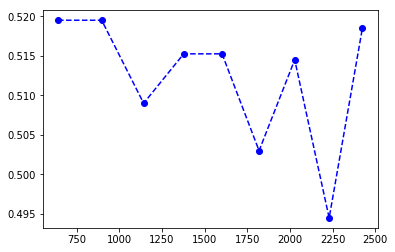

In [22]:
%%time

model5 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy5 = ActiveStrategy(model5, num_steps, margin, num_epochs, batch_size, num_workers)

def update_streaming_perc(inferred_res, threshold=5): # <-- here, threshold is the amount of data we want to keep
    perc = np.percentile([abs(float(x[2]-x[3])) for x in inferred_res], threshold)
    print(perc)
    next_loop = sorted(x[0] for x in inferred_res if abs(float(x[2]-x[3])) < perc)
    
    return next_loop
    
myStreamingAL2, myStepSizes2 = myActiveStrategy5.run_StreamingAL(update_streaming_perc, num_steps, num_train_triplets)
plt.plot(myStepSizes2, myStreamingAL2 , '--b', marker="o")

### Margin Sampling-Based Strategy

In [23]:
%%time
import operator

model6 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
myActiveStrategy6 = ActiveStrategy(model6, num_steps, margin, num_epochs, batch_size, num_workers)

def update_margin(inferred_res, nRec):
    #for k in range(len(inferred_res)):
        # Margin difference in confidence between the most confident classes
        #inferred_res[k].extend(list(zip(*sorted(enumerate(inferred_res[k][4]), key=operator.itemgetter(1))))[1][-2:])
    
    ranked = sorted(inferred_res, key=lambda x: float(abs(x[3] - x[2])))[:nRec] # margin low to high
    selected = [rec[0] for rec in ranked]
    
    return selected

myConfidenceAL4,length_labeled4 = myActiveStrategy6.run_ConfidenceAL(update_margin, num_steps, num_train_triplets)
# plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
#          length_labeled, myConfidenceAL3, '--g',
#          length_labeled4, myConfidenceAL4, '--p',
#          marker="o")

Training for 640 records:
Finished Training
Triplet Loss = 0.00933856
Accuracy of the network on the 2000 test images: 50.82500000000001%
Training for 1280 records:
Finished Training
Triplet Loss = 0.00943931
Accuracy of the network on the 2000 test images: 49.275000000000006%
Training for 1920 records:
Finished Training
Triplet Loss = 0.00934626
Accuracy of the network on the 2000 test images: 52.55000000000001%
Training for 2560 records:
Finished Training
Triplet Loss = 0.00944793
Accuracy of the network on the 2000 test images: 51.275000000000006%
Training for 3200 records:
Finished Training
Triplet Loss = 0.00948487
Accuracy of the network on the 2000 test images: 51.05%
Training for 3840 records:
Finished Training
Triplet Loss = 0.00940760
Accuracy of the network on the 2000 test images: 52.37500000000001%
Training for 4480 records:
Finished Training
Triplet Loss = 0.00944909
Accuracy of the network on the 2000 test images: 51.09999999999999%
Training for 5120 records:
Finished Tr

### Query-By-Committee Strategies

In [24]:
# %%time

# model7 = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
# myActiveStrategy7 = ActiveStrategy(model7, num_steps, margin, num_epochs, batch_size, num_workers)

# def QbCAL(nsteps, stepSize):
    
#     results = []
    
#     unlabeled = [i for i in range(num_train_triplets)]
#     labeled   = []

#     # Randomly sample what is to be labeled first...
#     to_be_labeled = random.sample(unlabeled, stepSize)
#     unlabeled = [i for i in range(len(unlabeled)) if i not in to_be_labeled]
    
#     for n in range(0, nsteps):
#         myAccuracy1 = myActiveStrategy7.run_one(to_be_labeled)
#         myResults1  = myActiveStrategy7.infer(unlabeled)
#         myAccuracy2 = myActiveStrategy7.run_one(to_be_labeled)
#         myResults2  = myActiveStrategy7.infer(unlabeled)
#         myAccuracy3 = myActiveStrategy7.run_one(to_be_labeled)
#         myResults3  = myActiveStrategy7.infer(unlabeled)
        
#         disagreement = []
# abs(float(x[2]-x[3]))
#         for r in range(len(unlabeled)):
#             dis = 0
#             if np.sign(float(myResults1[r][2]-myResults1[r][3])) != np.sign(float(myResults2[r][2]-myResults2[r][3])):
#                 dis += 1
#             if np.sign(float(myResults1[r][2]-myResults1[r][3])) != np.sign(float(myResults3[r][2]-myResults3[r][3])):
#                 dis += 1
#             if np.sign(float(myResults2[r][2]-myResults2[r][3])) != np.sign(float(myResults3[r][2]-myResults3[r][3])):   
#                 dis += 1
#             disagreement.append(dis)
        
#         sorted_by_disagree = sorted(zip(myResults1, disagreement), key=lambda x: x[-1])[:stepSize] # fill here; remember that the size of the array will be 'nps'

#         # update to_be_labeled:
#         to_be_labeled.extend([x[0] for x in [row[0] for row in sorted_by_disagree]])
#         to_be_labeled_set = set(to_be_labeled)
#         unlabeled = list(filter(lambda x: x not in to_be_labeled_set, unlabeled)) # update unlabeled

#         myres = myActiveStrategy7.run_one(to_be_labeled)
#         results.append(myres)        
        
#     return results
    
# myQbCAL = QbCAL(num_steps, nps)
# # plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b',
# #          length_labeled4, myConfidenceAL4, '--g',
# #          [nps*i for i in range(1, num_steps + 1)], myQbCAL,         '--p',
# #          marker="o")

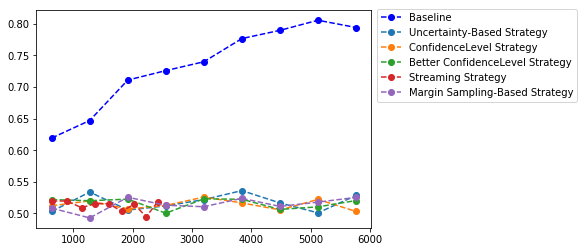

In [25]:
plt.plot([nps*i for i in range(1, num_steps + 1)], mySupervised,    '--b', label="Baseline",marker="o")
plt.plot([nps*i for i in range(1, num_steps + 1)], myConfidenceAL,  '--p', label="Uncertainty-Based Strategy",marker="o")
plt.plot([nps*i for i in range(1, num_steps + 1)], myConfidenceAL2, '--p', label="ConfidenceLevel Strategy",marker="o")
plt.plot(length_labeled, myConfidenceAL3, '--p', label="Better ConfidenceLevel Strategy",marker="o")
plt.plot(myStepSizes2, myStreamingAL2 , '--p', label="Streaming Strategy",marker="o")
plt.plot(length_labeled4, myConfidenceAL4, '--p', label="Margin Sampling-Based Strategy",marker="o")
#plt.plot([nps*i for i in range(1, num_steps + 1)], myQbCAL,'--p', label="Query-By-Committee Strategy",marker="o")
plt.legend(bbox_to_anchor=(1.63, 1.03))